# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load data

In [4]:
# Load data from hugging face
df = pd.read_parquet("hf://datasets/TimKoornstra/synthetic-financial-tweets-sentiment/data/train-00000-of-00001.parquet")

# Descriptive Analysis

In [4]:
print(f"Shape of the data set: {df.shape}")
print(df.head())

Shape of the data set: (1428771, 2)
                                               tweet  sentiment
0  💰 Cashing out stocks today has left me with a ...          2
1  💸 Losing half my investments in the last month...          2
2  📉 Crypto bubble finally bursts! The crypto tra...          2
3  🔥 The blazing inferno engulfs the stock market...          2
4  🥶 My stocks are stuck in an icy grip today. Fi...          2


In [5]:
df.isnull().sum()

tweet        0
sentiment    0
dtype: int64

There are no any  missing values

In [6]:
df['sentiment'].value_counts()

sentiment
1    486366
2    486133
0    456272
Name: count, dtype: int64

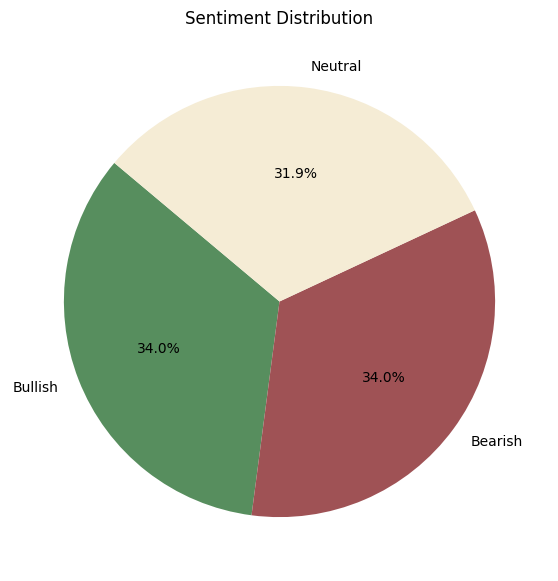

In [7]:
# Hex color codes for pastel-like colors
colors = ['#578E5E', '#9F5255', '#F5ECD5']  # green, red, pastel cream
labels = {0: 'Neutral', 1: 'Bullish', 2: 'Bearish'}

# Get sentiment counts and remap the labels
sentiment_counts = df['sentiment'].value_counts()
sentiment_labels = [labels[sent] for sent in sentiment_counts.index]

# Plot the pie chart
plt.figure(figsize=(7,7))
plt.pie(sentiment_counts, labels=sentiment_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.show()

Data set is a well balance data set

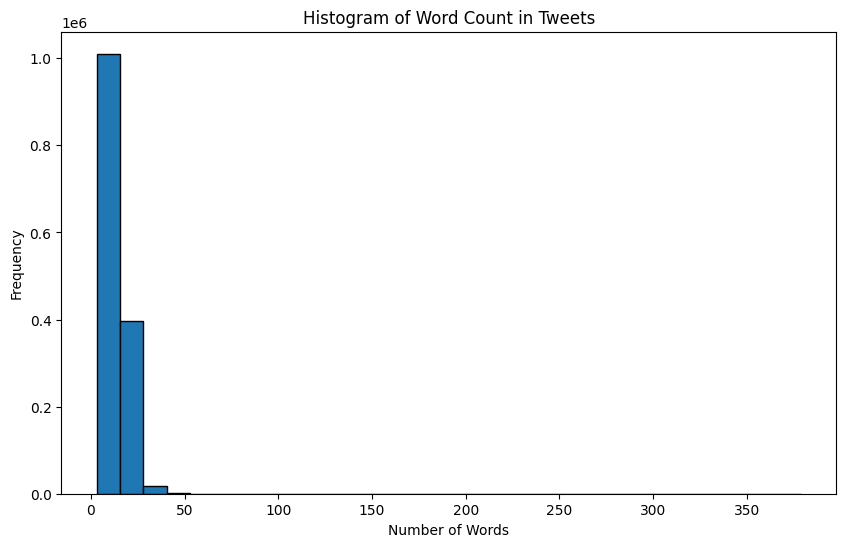

In [6]:
# Add a new column 'word_count' to count the number of words in each tweet
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))

# Plot a histogram of the word count
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=30, edgecolor='black')
plt.title('Histogram of Word Count in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

                                               tweet  sentiment  word_count
0  💰 Cashing out stocks today has left me with a ...          2          21
1  💸 Losing half my investments in the last month...          2          17
2  📉 Crypto bubble finally bursts! The crypto tra...          2          13
3  🔥 The blazing inferno engulfs the stock market...          2          13
4  🥶 My stocks are stuck in an icy grip today. Fi...          2          15


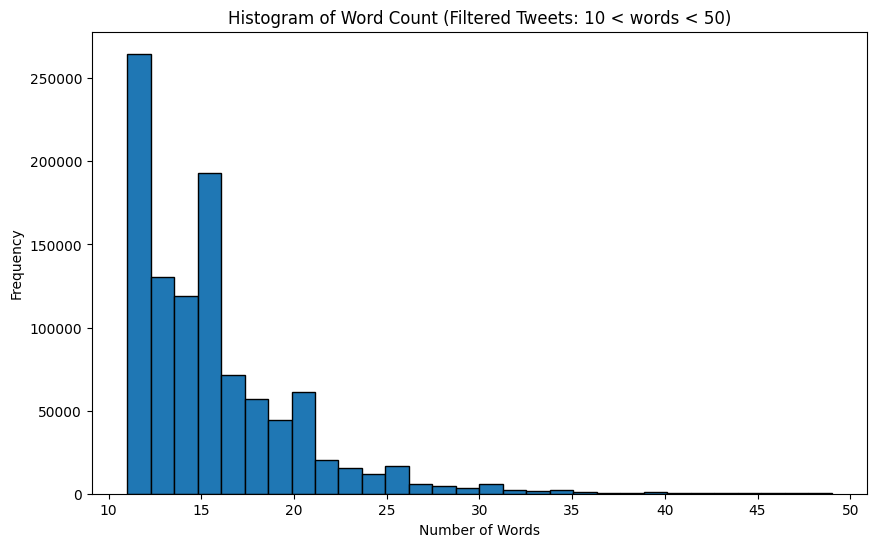

In [7]:
# Filter tweets with word count greater than 10 and less than 50
filtered_df = df[(df['word_count'] > 10) & (df['word_count'] < 50)]

# Display the first few rows of the filtered DataFrame
print(filtered_df.head())

# Plot a histogram for filtered tweets
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['word_count'], bins=30, edgecolor='black')
plt.title('Histogram of Word Count (Filtered Tweets: 10 < words < 50)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Reduce the dataset to 100,000 random samples
reduced_df = df.sample(n=1000, random_state=42)  # random_state ensures reproducibility

# Verify the new shape of the dataset
print(f"Shape of the reduced dataset: {reduced_df.shape}")

Shape of the reduced dataset: (1000, 3)


In [1]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

: 

In [9]:
# Load tokenizer and model (TensorFlow version)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = TFAutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)

# Split dataset into training and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(reduced_df['tweet'], reduced_df['sentiment'], test_size=0.2, random_state=42)

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(train_labels))).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(val_labels))).batch(16)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3  # You can adjust the number of epochs
)

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

/opt/anaconda3/envs/cse-sentiment-env/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Metal device set to: Apple M2

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



2025-01-04 20:55:49.698855: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-04 20:55:49.699102: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Epoch 1/3


2025-01-04 20:56:04.915484: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-01-04 20:56:04.924814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.8247 - accuracy: 0.7250

2025-01-04 20:57:49.220799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 128s 2s/step - loss: 0.8247 - accuracy: 0.7250 - val_loss: 0.3768 - val_accuracy: 0.8650
Epoch 2/3
50/50 [==============================] - 100s 2s/step - loss: 0.1260 - accuracy: 0.9538 - val_loss: 0.6194 - val_accuracy: 0.7900
Epoch 3/3
13/13 [==============================] - 8s 648ms/step - loss: 0.6656 - accuracy: 0.8450
Validation Loss: 0.6656417846679688
Validation Accuracy: 0.8450000286102295
